<a href="https://colab.research.google.com/github/choiking10/kaggle-competition/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tatatic

## Competition
[Titanic-Machine Learning from Disaster - overview](https://www.kaggle.com/c/titanic/overview)

Overview
The data has been split into two groups:

- training set (train.csv)
- test set (test.csv)

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

### Reference

[데이터 사이언스 스쿨 - 2.1 데이터 전처리 기초](https://datascienceschool.net/03%20machine%20learning/02.01%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EC%A0%84%EC%B2%98%EB%A6%AC%20%EA%B8%B0%EC%B4%88.html)  
[[이유한님] 캐글 코리아 캐글 스터디 커널 커리큘럼](https://kaggle-kr.tistory.com/32)

# Kaggle setup

In [1]:
!pip install kaggle
from google.colab import files

#ignore warnings
import warnings
warnings.filterwarnings('ignore')


# upload api token (kaggle.json)
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Prevent Permission Warning 
!chmod 600 ~/.kaggle/kaggle.json

# Dataset Download
! kaggle competitions download -c titanic


Saving kaggle.json to kaggle.json
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 24.5MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 3.31MB/s]
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 54.9MB/s]


# Titanic Data Overview


## Load Dataset

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Check Missing Data

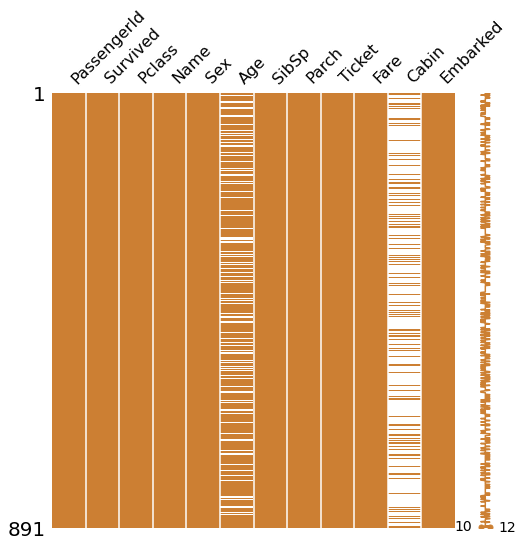

In [4]:
import missingno as msno

msno.matrix(df=train_data, figsize=(8, 8), color=(0.8, 0.5, 0.2))


## Data Distribution


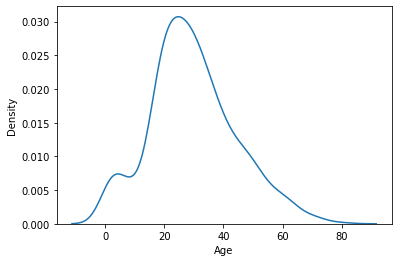

In [5]:
import seaborn as sns

sns.kdeplot(train_data.Age)

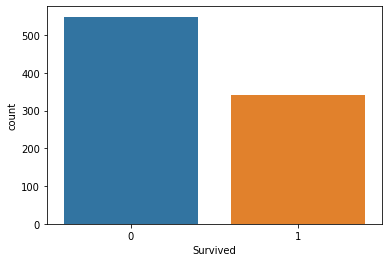

In [6]:
sns.countplot(train_data.Survived)

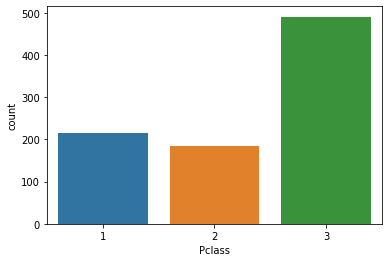

In [7]:
sns.countplot(train_data.Pclass)

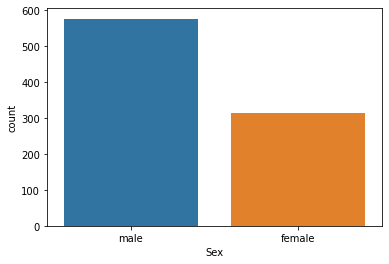

In [8]:
sns.countplot(train_data.Sex)

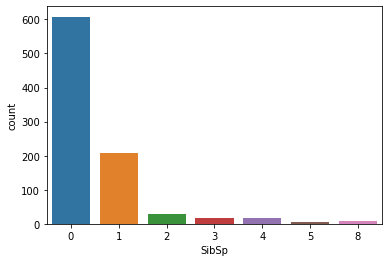

In [9]:
sns.countplot(train_data.SibSp)

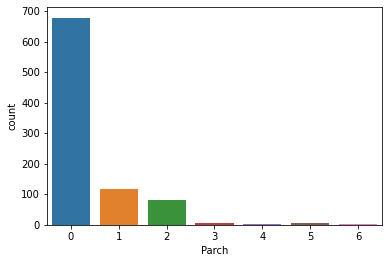

In [10]:
sns.countplot(train_data.Parch)

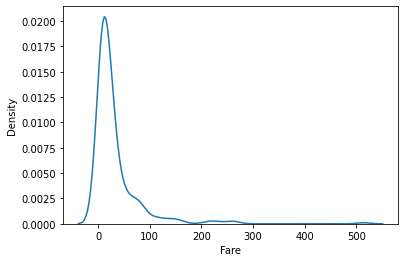

In [11]:
sns.kdeplot(train_data.Fare)

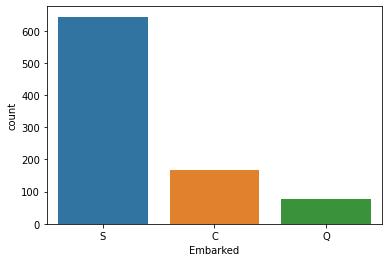

In [12]:
sns.countplot(train_data.Embarked)

In [13]:
train_data["Ticket"].str.extract(r"([a-zA-Z0-9]+)$").nunique()

0    679
dtype: int64

## Data Correlation

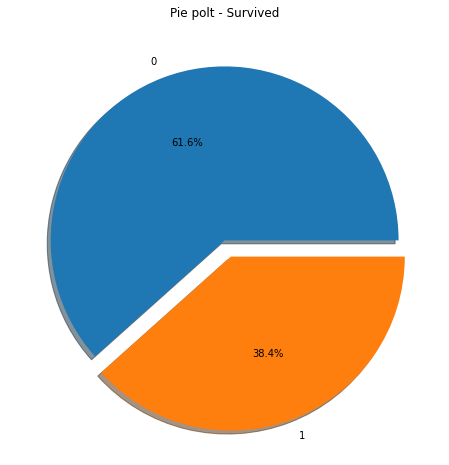

In [14]:
# f, ax = plt.subplots(1, figsize=(8, 8))

train_data["Survived"].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', figsize=(8,8),shadow=True, title="Pie polt - Survived", ylabel="")


In [15]:
train_data[['Pclass', 'Survived']].groupby(["Pclass"], as_index=True).count()

,Survived
Pclass,
1,216
2,184
3,491


In [16]:
pd.crosstab(train_data["Pclass"], train_data["Survived"], margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


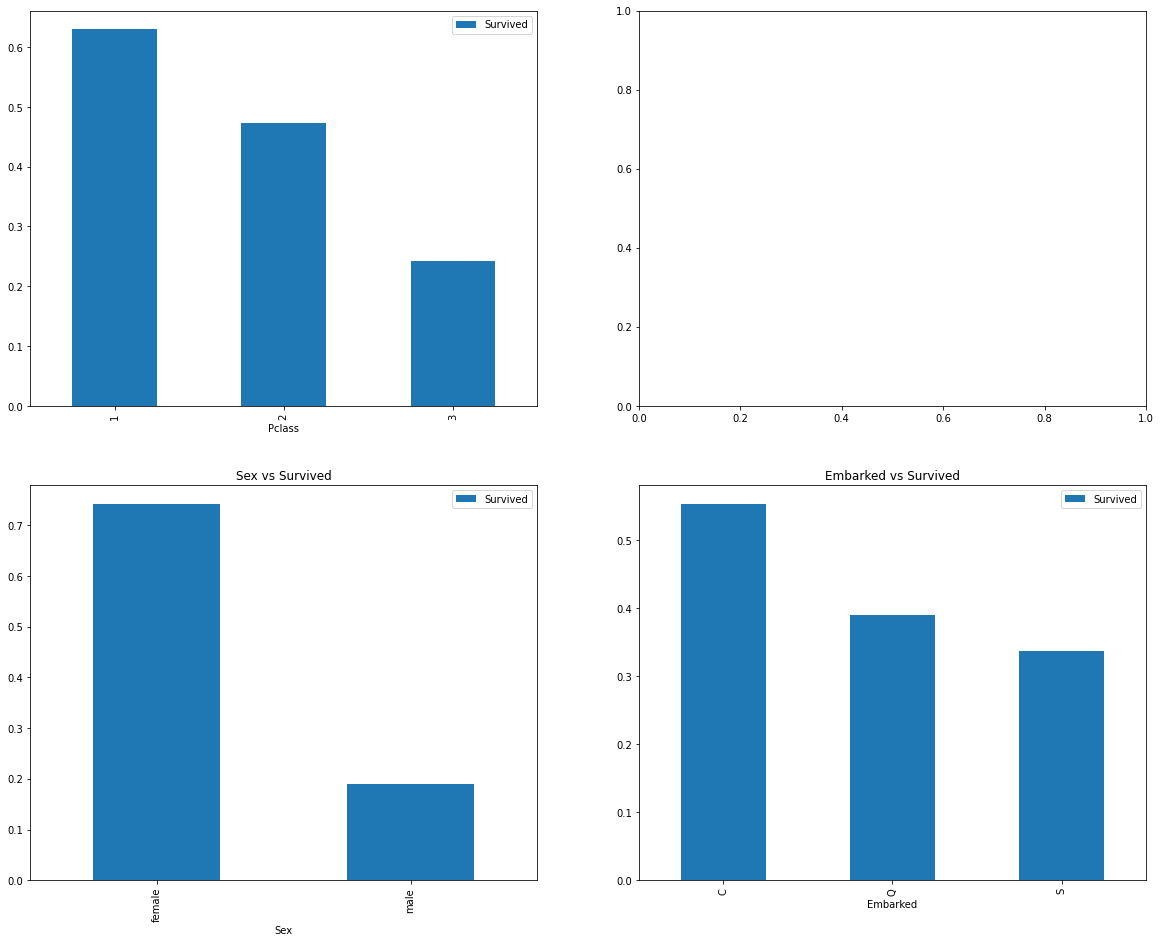

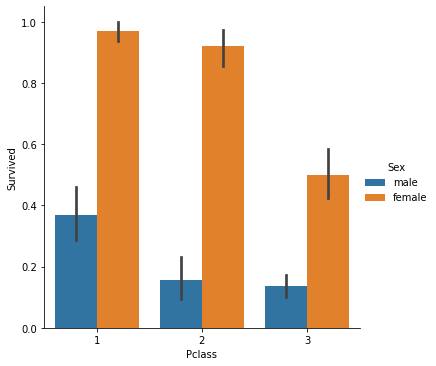

In [99]:
f, ax = plt.subplots(2, 2, figsize=(20, 16))

# sns.countplot('Sex', hue='Survived', data=train_data,ax=ax[0, 0])
# ax[0, 0].set_title("Sex: Dead vs Survived")

# sns.countplot('Embarked', hue="Survived", data=train_data, ax=ax[0, 1])
# ax[0, 1].set_title("Embarked: Dead vs Survived")

# 이거가 중요한 insight 각 Column 별로 상관관계를 분석 가능
train_data[["Pclass", "Survived"]].groupby("Pclass", as_index=True).mean().sort_values("Survived", ascending=False).plot.bar(ax=ax[0, 0])
# 이거가 중요한 insight 각 Column 별로 상관관계를 분석 가능
ax[0, 1] = sns.catplot(x="Pclass", y="Survived", hue="Sex", kind="bar", data=train_data)
# sns.barplot(train_data[["Sex", "Pclass", "Survived"]].groupby(["Sex", "Pclass"], as_index=True).mean(), hue="Sex", ax=ax[0, 1])
# 모두 불균형이 어느정도 있음
#
train_data[["Sex", "Survived"]].groupby(["Sex"], as_index=True).mean().sort_values("Survived", ascending=False).plot.bar(ax=ax[1, 0])
ax[1, 0].set_title("Sex vs Survived")
train_data[["Embarked", "Survived"]].groupby(["Embarked"], as_index=True).mean().sort_values("Survived", ascending=False).plot.bar(ax=ax[1, 1])
ax[1, 1].set_title("Embarked vs Survived")
f.show()

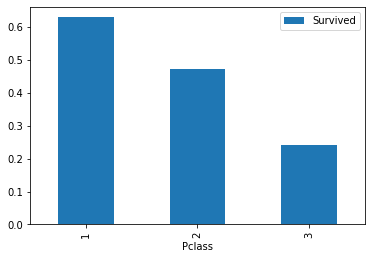

In [24]:
train_data[["Pclass", "Survived"]].groupby("Pclass").mean().plot.bar()

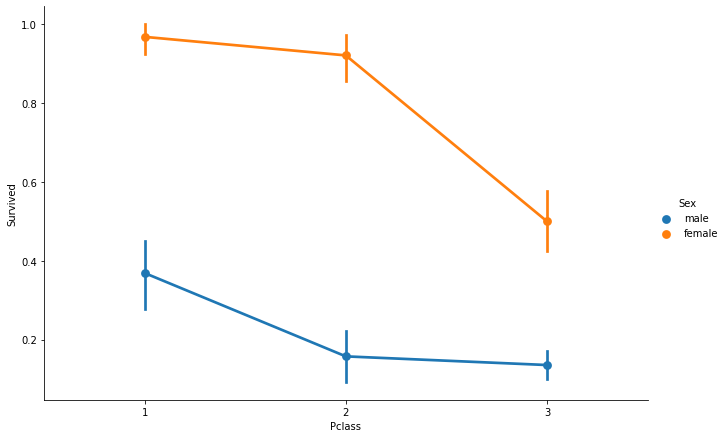

In [19]:
sns.factorplot('Pclass', 'Survived', hue="Sex", data=train_data, size=6, aspect=1.5)

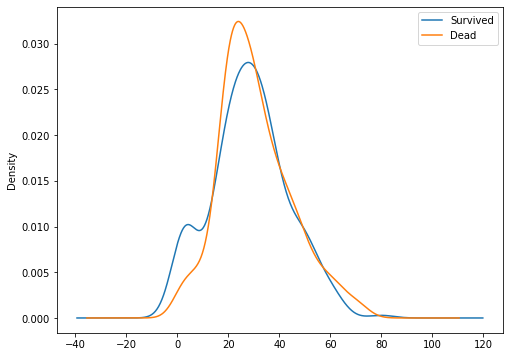

In [20]:
plt.figure(figsize=(8, 6))

train_data[train_data["Survived"]==1]["Age"].plot(kind='kde')
train_data[train_data["Survived"]==0]["Age"].plot(kind='kde')

plt.legend(['Survived', 'Dead'])

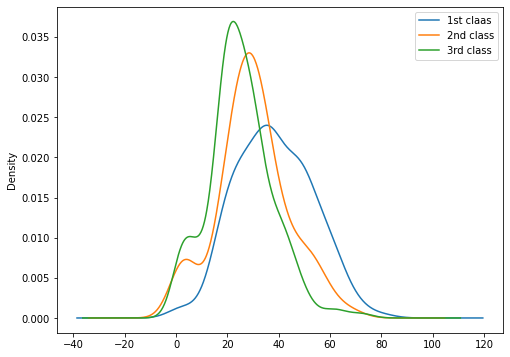

In [32]:
plt.figure(figsize=(8, 6))

train_data[train_data["Pclass"]==1]["Age"].plot(kind='kde')
train_data[train_data["Pclass"]==2]["Age"].plot(kind='kde')
train_data[train_data["Pclass"]==3]["Age"].plot(kind='kde')

plt.legend(['1st claas', '2nd class', '3rd class'])

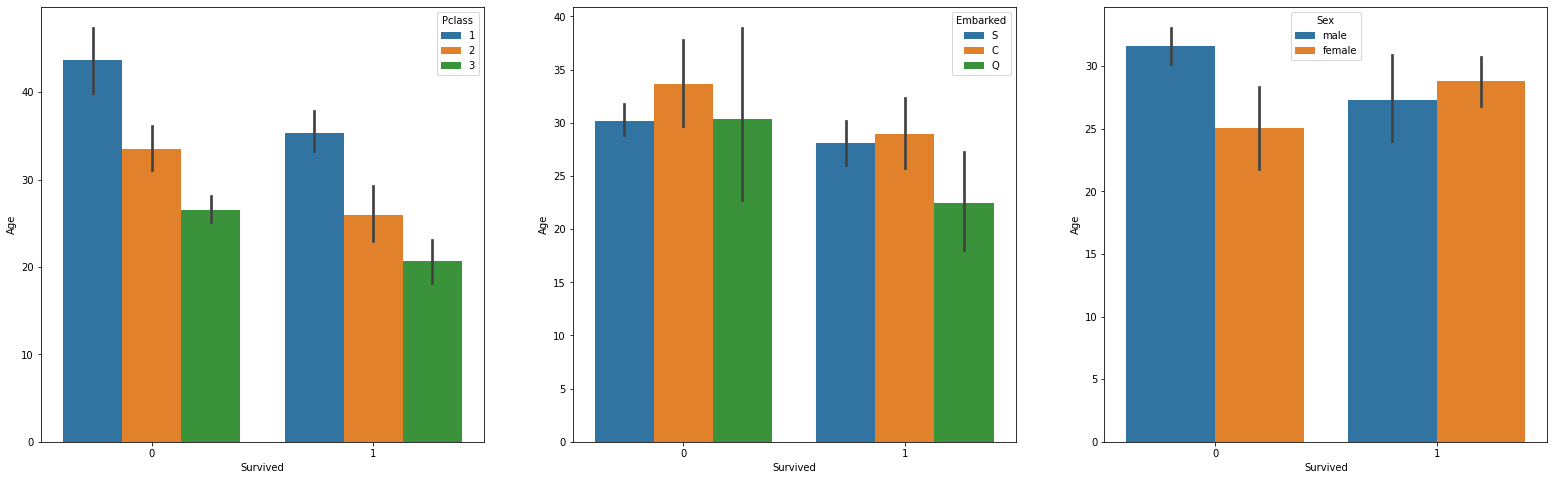

In [69]:
f, ax = plt.subplots(1, 3, figsize=(27, 8))
sns.barplot("Survived", "Age", hue="Pclass", data=train_data, ax=ax[0])
# sns.violinplot("Embarked", "Age", hue="Survived", data=train_data, ax=ax[1], split=True)
sns.barplot("Survived", "Age", hue="Embarked", data=train_data, ax=ax[1])
sns.barplot("Survived", "Age", hue="Sex", data=train_data, ax=ax[2])

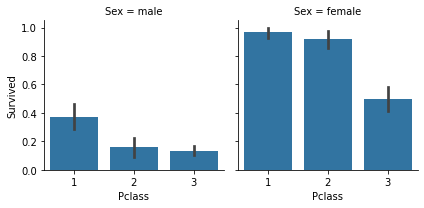

In [72]:
g = sns.FacetGrid(train_data, col="Sex")
g.map(sns.barplot, "Pclass", "Survived")

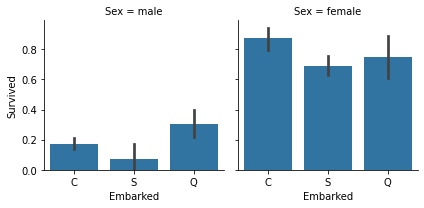

In [73]:
g = sns.FacetGrid(train_data, col="Sex")
g.map(sns.barplot, "Embarked", "Survived")

In [ ]:
g = sns.FacetGrid(train_data, col="Sex")
g.map(sns.barplot, "Embarked", "Survived")

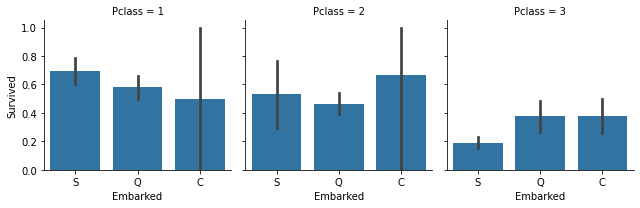

In [75]:
g = sns.FacetGrid(train_data, col="Pclass")
g.map(sns.barplot, "Embarked", "Survived")

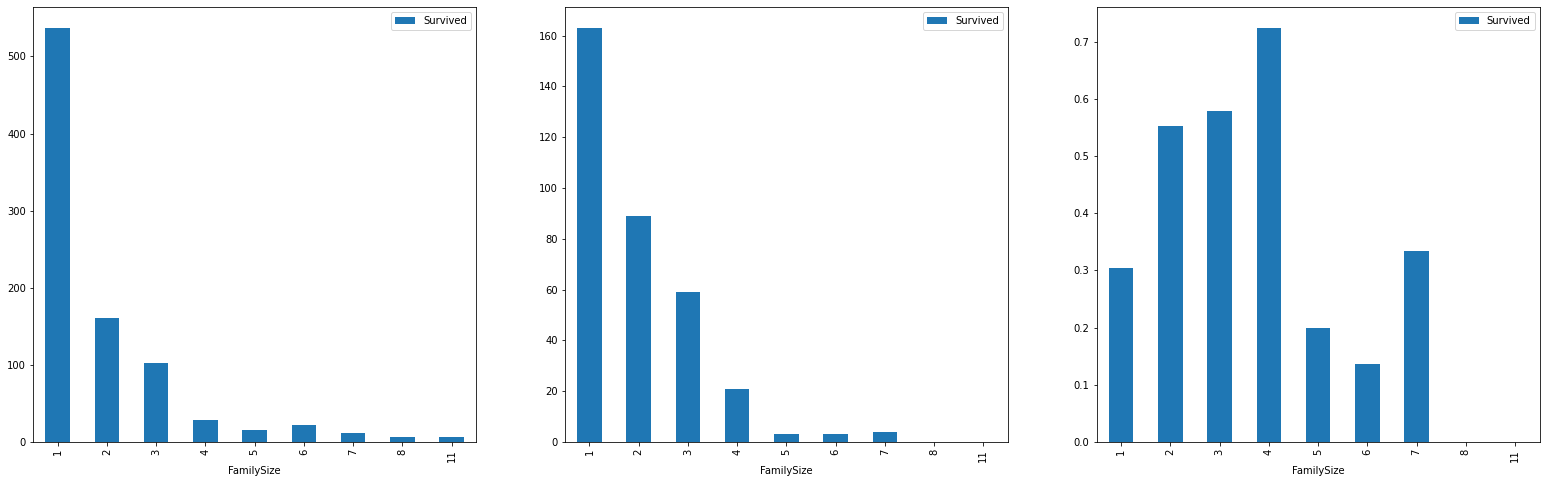

In [85]:
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1

f, ax = plt.subplots(1, 3, figsize=(27, 8))
train_data[['FamilySize', 'Survived']].groupby("FamilySize", as_index=True).count().plot.bar(ax=ax[0])
train_data[['FamilySize', 'Survived']].groupby("FamilySize", as_index=True).sum().plot.bar(ax=ax[1])
train_data[['FamilySize', 'Survived']].groupby("FamilySize", as_index=True).mean().plot.bar(ax=ax[2])

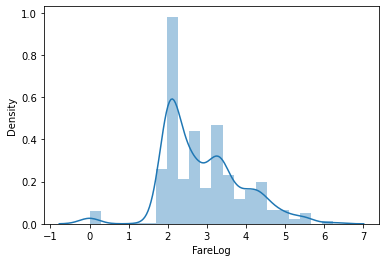

In [90]:
import numpy as np
train_data['FareLog'] = train_data["Fare"].map(lambda x: np.log(x) if x > 0 else 0)
sns.distplot(train_data['FareLog'])

# Feature Engineering



## Data Cleansing

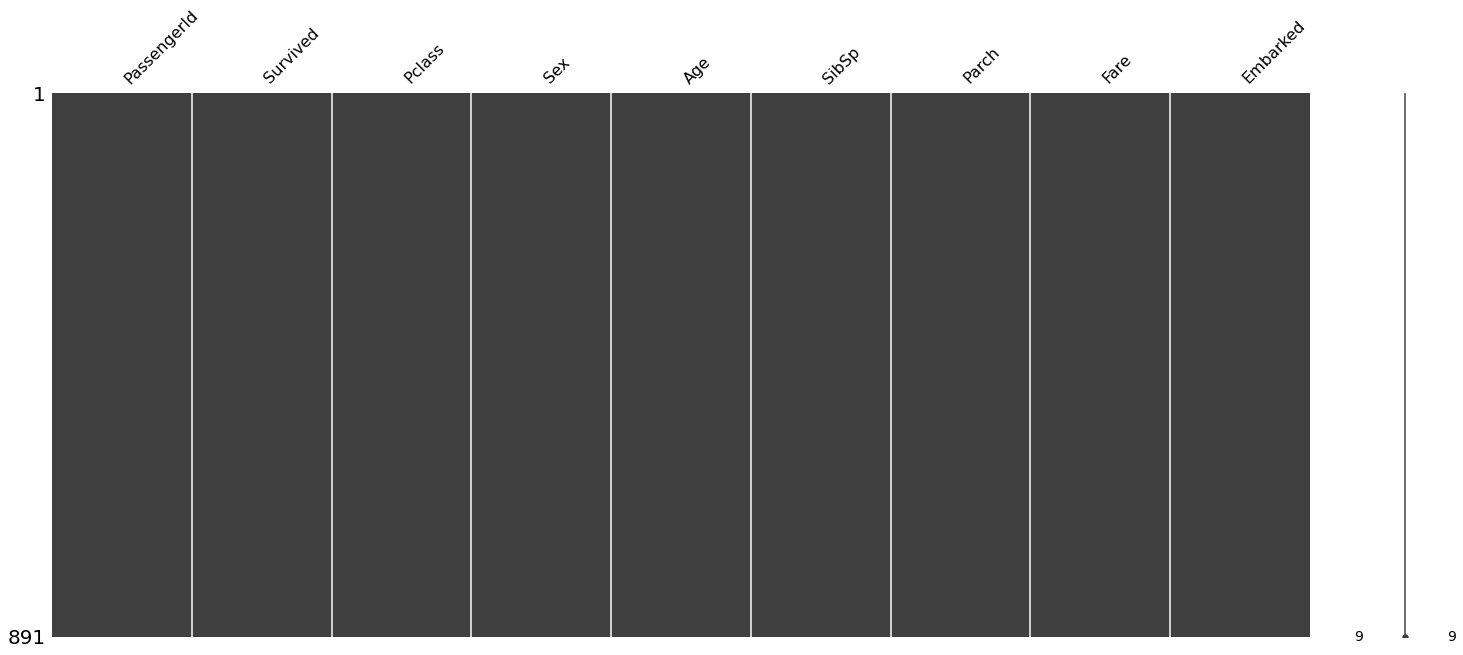

In [21]:
import seaborn as sns
from patsy import dmatrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# sns.kdeplot(train["Age"])

# Missing Data: Age, Embarked, Cabin

# remove column which have too many NaN value
cleaned_train_data = train_data.dropna(thresh=int(len(train_data) * 0.5), axis=1)  # Remove Cabin

frequentImputer = SimpleImputer(strategy="most_frequent")
medianImputer = SimpleImputer(strategy="median")

cleaned_train_data.loc[:,"Embarked"] = frequentImputer.fit_transform(cleaned_train_data[["Embarked"]]).copy()
cleaned_train_data.loc[:,"Age"] = medianImputer.fit_transform(cleaned_train_data[["Age"]].copy())

# ["Ticket", "Name"] maybe useless.
cleaned_train_data = cleaned_train_data.drop(["Ticket", "Name"], axis=1)

msno.matrix(cleaned_train_data)

In [22]:

# 
# scaler = StandardScaler()
# train["Age"] = scaler.fit_transform(cleaned_train_data["Age"].values.reshape(-1, 1))

# train